In [14]:
%matplotlib widget
import os
import glob
import cuvis
import cuvis_ai
import numpy as np
from PIL import Image as Img
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ipywidgets import interact
import matplotlib

## Distance Based Classification

### Objective: Apply various distance based classification metrics to hyperspectral datacubes

### Data: Aquarium

In this notebook, we will be using a CUVIS.AI session file (video file) which contains multiple sequential hyperspectral datacubes. You will load the data, select representative spectral from each of the cubes, and then score the distance of each pixel to each of the spectra you chose. We will then classify each pixel based on their distance to the spectra.

To get started, we will download a dataset from Google Drive using Cuvis.AI

In [2]:
try:
    base_path = "../data/cuvis_ai_video"
    os.mkdir(base_path)
except FileExistsError as e:
    pass
if not os.path.exists("../data/cuvis_ai_video/Aquarium_Sample.cu3s"):
    data_down = cuvis_ai.data.PublicDataSets()
    data_down.download_dataset("Aquarium", download_path=base_path)

Now that we've downloaded the data, let's pick spectra. In the scene there are fish, plants, and water, Try picking a pixel for each!

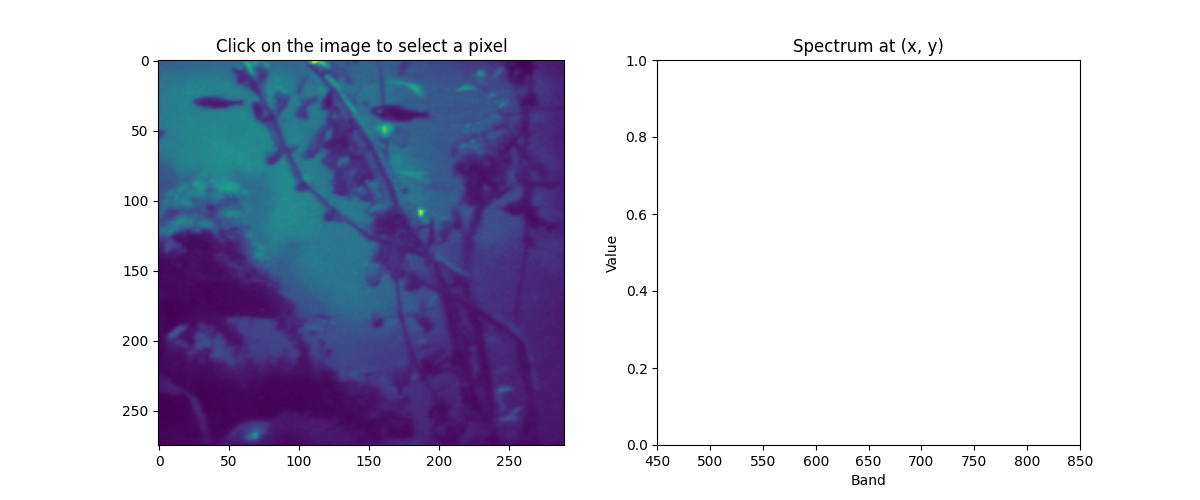

In [ ]:
# Let's look at a single example
cubes = glob.glob(f'{base_path}/*.cu3s')
data = cuvis.SessionFile(cubes[0]).get_measurement(0)
sample_cube = data.data.get('cube').array
waves = data.data.get('cube').wavelength

# Store clicked spectra and locations
picked_spectra = []  # Each item: (x, y, spectrum)
colors = matplotlib.colormaps.get_cmap("tab10") # Use matplotlib tab10 colormap

# Create the plot
fig, (ax_img, ax_spec) = plt.subplots(1, 2, figsize=(12, 5))
img_handle = ax_img.imshow(sample_cube[:,:,10])
# spec_handle, = ax_spec.plot(waves, np.zeros(len(waves)))
ax_spec.set_xlim([min(waves), max(waves)])
scatter_handle = ax_img.scatter([], [], s=30, label='Picked Points')

ax_spec.set_title("Spectrum at (x, y)")
ax_spec.set_xlabel("Band")
ax_spec.set_ylabel("Value")
ax_img.set_title("Click on the image to select a pixel")
# Store line handles for updating the legend
line_handles = []
scatter_coords = []       # List of (x, y)
scatter_colors = []       # List of RGB tuples
# Update spectrum and marker on click
def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)

    # Extract spectrum
    spectrum = sample_cube[y, x, :]
    picked_spectra.append((spectrum.copy()))
    scatter_coords.append((x, y))

    # Choose a color from colormap
    color = colors(len(picked_spectra) % 10)
    scatter_colors.append(color)

    # Update scatter plot
    coords_array = np.array(scatter_coords)
    scatter_handle.set_offsets(coords_array)
    scatter_handle.set_color(scatter_colors)

    # Plot spectrum with label and color
    line, = ax_spec.plot(waves, spectrum, color=color, label=f"({x}, {y})")
    line_handles.append(line)
    ax_spec.legend(handles=line_handles, loc='upper right', fontsize=8)
    fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

### Defining a distance based classification graph

Now that we've picked and visualized some spectra, we're now ready to begin creating a pipeline to perform distance-based classification.

In this first example, we'll define a spectral angle mapper (SAM) based classifier. SAM is a classically hyperspectral method to compare the shapes of spectra. It is relatively invariant to changes in intensity.

In [34]:
# Define SAM node
sam = cuvis_ai.distance.SpectralAngle(ref_spectra=np.array(picked_spectra))

We now want to define a metric for deciding which spectra the pixel in our cube are closest to. We'll simply pick the one with the smallest distance, which we use through a `MultiClassDecider` node.

In [35]:
# Distance decider node
decider = cuvis_ai.deciders.MultiClassDecider(len(picked_spectra), use_min=True)

Now that we have this simple, two-stage node, we connect them indicating the SAM node will be the entry point for data, which will then flow to the decider node.

*This will throw an initialization warning "Unsatisfied dimensionality constraint", but this is expected behavior*

In [36]:
graph = cuvis_ai.pipeline.Graph("DemoGraph")
graph.add_base_node(sam)
graph.add_edge(sam, decider)

Unsatisfied dimensionality constraint!


Cuvis.AI has methods for handling large number of datacubes, including our session file which has over 200 images in it. We'll define it as a dataset to pass into the graph.

This dataset is *unlabeled*, meaning it only contains the raw hyperspectral datacubes, and not label files.

In [37]:
# Define unlabeled dataset
data = cuvis_ai.data.CuvisDataSet(base_path)

ERROR:root:Last function returned 'ok'.
NoneType: None


Reading from directory: ../data/cuvis_ai_video
Found file: ../data/cuvis_ai_video/Aquarium_Sample.cu3s
Session file has 251 cubes


This graph does not require training since we have selected representative points, and there is nothing for the model to learn. Let's inspect the output of the `forward` method.

In [ ]:
# Fit the graph using the first image
print(graph.forward(*data[0:1]).shape)

/home/nathaniel/anaconda3/envs/cubert_dev/lib/python3.12/site-packages/cuvis_ai/distance/distance.py:225: UserWarning: Spectral angle mapper is being used without properly normalized data. Unexpected behavior may occur!
  warnings.warn(
/home/nathaniel/anaconda3/envs/cubert_dev/lib/python3.12/site-packages/cuvis_ai/distance/distance.py:231: RuntimeWarning: invalid value encountered in arccos
  output_scores.append(np.arccos(


(1, 275, 290, 1)

The output here is a 4 dimensional array. We can pass multiple hyperspectral images through the graph at once in batches, which will change the value of the first dimension of the array. Since we only passed a single image through, we have a shape of 1, followed by the shape of the output result (275, 290, 1) which corresponds to the width, height, and matching spectrum number for each pixel.

### Visualize the Results

Now that we have defined a graph in cuvis.ai, we can use it to classify all the images in dataset. The cells below will generate and display showing the classification applied to the video and rendered as a gif.

  0%|          | 0/251 [00:00<?, ?it/s]

/home/nathaniel/anaconda3/envs/cubert_dev/lib/python3.12/site-packages/cuvis_ai/distance/distance.py:225: UserWarning: Spectral angle mapper is being used without properly normalized data. Unexpected behavior may occur!
  warnings.warn(
/home/nathaniel/anaconda3/envs/cubert_dev/lib/python3.12/site-packages/cuvis_ai/distance/distance.py:231: RuntimeWarning: invalid value encountered in arccos
  output_scores.append(np.arccos(


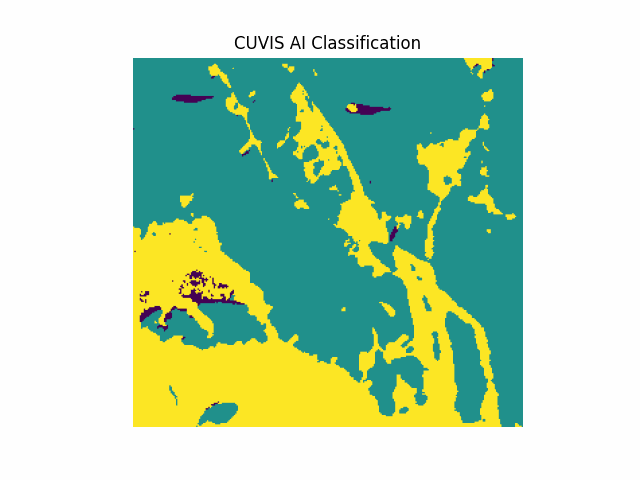

In [44]:
# Generate gifs of session file classification
for i in tqdm.tqdm(range(len(data))):
    res_show = graph.forward(*data[i:i+1])
    plt.figure()
    plt.imshow(res_show[0,:,:,:])  # Example plot
    plt.title('CUVIS AI Classification')
    filename = os.path.join(base_path
    , f"frame_{i}.png")
    plt.axis('off')
    plt.savefig(filename)
    plt.close()

# Save as an animated GIF

# Collect all the frames
frames = []
for i in range(len(data)):
    filename = os.path.join(base_path, f"frame_{i}.png")
    frames.append(Img.open(filename))
    
# Define save path
gif_path = os.path.join(base_path, "cuvis_fishtank_example_sam.gif")
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=50,  # Duration between frames in milliseconds
    loop=0  # Loop forever
)
for f in glob.glob(f"{base_path}/frame_*.png"):
    os.remove(f)

# Render the gif in the notebook
display(Image(filename=gif_path))

### Next Steps

While SAM is effective for some classification tasks, other distance based metrics have been proposed in the literature. cuvis.ai implements the following methods.

- Spectral Angle Mapper
- Euclidean Distance
- Manhattan Distance
- Canberra Distance
- Minkowski Distance
- Goodness-of-fit Coefficient (GFC)
- Euclidean Distance of Cumulative Spectrum (ECS)

Take a peek at the [source code](https://github.com/cubert-hyperspectral/cuvis.ai/blob/main/cuvis_ai/distance/distance.py) and try out a different one with the dataset!